In [1]:
import keras
from PIL import Image

import datetime
import numpy as np
import tensorflow as tf
import MobileUNet as mu

csv_path = tf.train.string_input_producer(['dataset.csv'], shuffle=False, name='csv_path')

reader = tf.TextLineReader()
key, value = reader.read(csv_path)

# Read image path and label(Annotations) path
record_defaults = [[""],[""],[0.]]
im_name, label, _ = tf.decode_csv(value, record_defaults=record_defaults)


# Load images from image_path above
im_content = tf.read_file(im_name)
image = tf.image.decode_png(im_content, channels=3)
image = tf.cast(image, tf.float32)
image = tf.image.resize_images(image, [64, 64])

label_content = tf.read_file(label)
label = tf.image.decode_png(label_content, channels=1)
label = tf.cast(label, tf.float32)
label = tf.image.resize_images(label, [64, 64])

train_x_batch, train_y_batch = tf.train.batch([image, label], batch_size=32)

learning_rate = 0.0001
training_epochs = 100
batch_size = 32
num_batch = 20100 // batch_size

X_ph = tf.placeholder(tf.float32, [None, 64, 64, 3])
Y_ph = tf.placeholder(tf.float32, [None, 64, 64, 2])

net = mu.build_mobile_unet(X_ph, 2)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net,
                                                              labels=Y_ph))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())


# Start populating the filename queue.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
saver = tf.train.Saver()
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)


# train my model
print('Learning started.')
train_y_batch = tf.divide(train_y_batch, 255)
print("shape check", train_y_batch.shape)
train_y_batch = tf.squeeze(train_y_batch)
print("shape double check", train_y_batch.shape)
x_batch, y_batch = sess.run([train_x_batch, train_y_batch]) # Since, we can't feed tensor
one_hot_labels = keras.utils.to_categorical(y_batch, num_classes=2)
print("shape tripple check", one_hot_labels.shape)

for epoch in range(training_epochs):
    avg_cost = 0
    for step in range(num_batch):
        annotations, cost_val, _ = sess.run([net, cost, optimizer], 
                                 feed_dict={X_ph: x_batch, Y_ph: one_hot_labels})
        avg_cost += cost_val / num_batch
        #if step % 10 == 0:
        #    print(step, "Cost: ", cost_val)
    print('Epoch:', '%04d' % (epoch + 1),
          'cost =', '{:.9f}'.format(avg_cost))
save_path = saver.save(sess, "saved_networks/" + date_time)
print("Learning Done!")
coord.request_stop()
coord.join(threads)

Using TensorFlow backend.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning started.
shape check (32, 64, 64, 1)
shape double check (32, 64, 64)
shape tripple check (32, 64, 64, 2)
Epoch: 0001 cost = 0.157893645
Epoch: 0002 cost = 0.020378277
Epoch: 0003 cost = 0.008596358
Epoch: 0004 cost = 0.004550507
Epoch: 0005 cost = 0.002678727
Epoch: 0006 cost = 0.001673282
Epoch: 0007 cost = 0.001084810


KeyboardInterrupt: 

In [53]:
test = np.argmax(annotations, axis=3)

In [54]:
denormalized_test = test*255

In [56]:
denormalized_test.shape

(32, 64, 64)

In [60]:
denormalized_test[25].min()

0

In [63]:
im1= Image.fromarray(np.uint8(denormalized_test[25]))

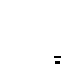

In [64]:
im1

In [65]:
im2= Image.fromarray(np.uint8(denormalized_test[26]))

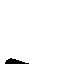

In [66]:
im2